In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops import masks_to_boxes
import torch.optim as optim
from torchvision import transforms as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
# --- CustomDataset ---
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # Mask grayscale
        
        image_tensor = self.transform(image) if self.transform else image

        # Convert mask to numpy array before creating tensor
        mask_np = np.array(mask)
        # Binarize mask numpy array
        mask_np = (mask_np > 0).astype(np.uint8) # Convert to 0 and 1 value, uint8 datatype
        # Convert binarized numpy mask to tensor
        mask_tensor = torch.from_numpy(mask_np).bool() # Cvt to boolean tensor

        return image_tensor, mask_tensor # Return image tensor and mask boolean tensor

In [3]:
# --- Transform (just for images) ---
transform = transforms.Compose([
    transforms.ToTensor(),
])

# --- Dataset và DataLoader---
train_dataset = CustomDataset('/kaggle/input/mask-chesspieces-dataset/dataset_split/train/images', '/kaggle/input/mask-chesspieces-dataset/dataset_split/train/masks', transform=transform)
val_dataset = CustomDataset('/kaggle/input/mask-chesspieces-dataset/dataset_split/val/images', '/kaggle/input/mask-chesspieces-dataset/dataset_split/val/masks', transform=transform)
test_dataset = CustomDataset('/kaggle/input/mask-chesspieces-dataset/dataset_split/test/images', '/kaggle/input/mask-chesspieces-dataset/dataset_split/test/masks', transform=transform)

# Create DataLoader
# Important note: For target to work properly with Mash R-CNN, we need to custom collate_fn
# because targerts (boxes, labels, masks) can have different sizes betwwen images in the batch ì các target (boxes, labels, masks) có thể khác kích thước giữa các ảnh trong batch.
# The default Dataloader will try to stack them and cause an error.
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [4]:
# --- Download model and feature extraction ---
model = maskrcnn_resnet50_fpn(pretrained=True)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
num_classes = 2 # 1 class foreground + 1 class background
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Need to change box_predictor if there is only 1 foreground layer
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)


# --- Device ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 170MB/s]  


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [5]:
# --- Func compute IoU and Pixel Accuracy ---
def iou_metric(pred, target):
    pred = pred.bool()
    target = target.bool()
    intersection = (pred & target).float().sum()
    union = (pred | target).float().sum()
    # Add small epsilon to avoid div by 0
    return intersection / (union + 1e-6) if union > 0 else torch.tensor(0.0, device=pred.device)
    
def pixel_accuracy(pred, target):
    correct = (pred == target).float().sum()
    total = target.numel()
    return correct / total if total > 0 else torch.tensor(0.0, device=pred.device)

In [6]:
# ---  optimizer ---
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

best_iou = 0.0
num_epochs = 10

# --- Train and Valid ---
for epoch in range(num_epochs):
    # === Train ===
    model.train()
    train_loss = 0.0
    for i, (images, targets_masks) in enumerate(train_loader): 
        images = list(image.to(device) for image in images)
        targets = []
        for mask_tensor in targets_masks:
            mask_tensor = mask_tensor.to(device) # Already a boolean tensor from Dataset
            if mask_tensor.ndim != 2:
                 print(f"Skipping mask with unexpected shape: {mask_tensor.shape}")
                 # Or handle it differently if the mask can have multiple channels/instances
                 # A simple example is to ignore this target:
                 # targets.append(None) # Need to handle None in model call or filter later
                 # In this case, create an empty target to avoid model call errors.
                 boxes = torch.zeros((0, 4), dtype=torch.float32, device=device)
                 labels = torch.zeros(0, dtype=torch.int64, device=device)
                 masks_for_target = torch.zeros((0, mask_tensor.shape[-2], mask_tensor.shape[-1]), dtype=torch.uint8, device=device)
            else:
                 # masks_to_boxes requires mask to have batch dimension and be uint8 or bool
                 # If mask is empty (all False), masks_to_boxes will return box [0,0,0,0]
                 # We need to handle this case to avoid errors or unwanted results.
                 pos = torch.where(mask_tensor) # Find foreground pixels
                 if pos[0].numel() > 0: # If there is at least 1 foreground pixel
                      # masks_to_boxes requires input of the form [N, H, W]
                      boxes = masks_to_boxes(mask_tensor.unsqueeze(0))
                      # Make sure there is only 1 box if the mask has only 1 instance
                      if boxes.shape[0] > 1:
                           # You can combine boxes or choose the largest box, here take the outermost box
                           x_min = boxes[:, 0].min()
                           y_min = boxes[:, 1].min()
                           x_max = boxes[:, 2].max()
                           y_max = boxes[:, 3].max()
                           boxes = torch.tensor([[x_min, y_min, x_max, y_max]], device=device)

                      labels = torch.ones((boxes.shape[0],), dtype=torch.int64, device=device) # label foreground (class 1)
                      # RCNN mask requires target['masks'] to be [N, H, W] and of type uint8 or bool
                      masks_for_target = mask_tensor.unsqueeze(0).type(torch.uint8) # Chuyển sang uint8
                 else: # Mask has no foreground pixel
                      boxes = torch.zeros((0, 4), dtype=torch.float32, device=device)
                      labels = torch.zeros(0, dtype=torch.int64, device=device)
                      masks_for_target = torch.zeros((0, mask_tensor.shape[0], mask_tensor.shape[1]), dtype=torch.uint8, device=device)


            targets.append({'boxes': boxes, 'labels': labels, 'masks': masks_for_target})

        # Lọc bỏ các target None nếu có bước xử lý lỗi ở trên
        # valid_indices = [idx for idx, t in enumerate(targets) if t is not None]
        # images = [images[i] for i in valid_indices]
        # targets = [targets[i] for i in valid_indices]
        # if not images: continue # Bỏ qua batch nếu không còn ảnh hợp lệ

        try:
             loss_dict = model(images, targets)
             losses = sum(loss for loss in loss_dict.values())

             # Check for valid loss
             if not torch.isfinite(losses):
                  print(f"Epoch {epoch+1}, Iter {i}: Non-finite loss detected: {loss_dict}")
                  # Can add logic to save state or stop early
                  continue # Skip this update step

             train_loss += losses.item()

             optimizer.zero_grad()
             losses.backward()
             optimizer.step()
        except Exception as e:
             print(f"Error during training step: {e}")
             print(f"Image shapes: {[img.shape for img in images]}")
             for j, t in enumerate(targets):
                  print(f"Target {j}: boxes={t['boxes'].shape}, labels={t['labels'].shape}, masks={t['masks'].shape}")
             # You can add debug or skip this batch.
             continue

    train_loss /= len(train_loader) # Divide by the number of batches

    # === Đánh giá trên tập validation ===
    model.eval()
    total_iou = 0.0
    total_correct_pixels = 0
    total_pixels = 0
    num_samples = 0 # Đếm số lượng ảnh đã đánh giá

    with torch.no_grad():
        for images, targets_masks in val_loader:
            images = list(image.to(device) for image in images)
            masks_gt = list(mask.to(device) for mask in targets_masks) # Ground truth masks

            # Dự đoán
            outputs = model(images)

            # Tính toán metrics cho từng ảnh trong batch
            for output, mask_gt in zip(outputs, masks_gt):
                 mask_gt = mask_gt.squeeze().bool() # Ground truth mask [H, W] boolean

                 if mask_gt.ndim != 2:
                     print(f"Skipping validation mask with unexpected shape: {mask_gt.shape}")
                     continue # Bỏ qua sample này nếu mask không đúng shape

                 if len(output['masks']) == 0:
                     # Nếu model không dự đoán mask nào, tạo mask rỗng
                     pred_mask_final = torch.zeros_like(mask_gt, dtype=torch.bool, device=device)
                 else:
                     # Lấy mask có score cao nhất
                     best_idx = torch.argmax(output['scores'])
                     pred_mask_final = (output['masks'][best_idx, 0] > 0.5).bool() # Mask dự đoán tốt nhất [H, W] boolean

                 # Đảm bảo kích thước không gian khớp nhau (quan trọng!)
                 if pred_mask_final.shape != mask_gt.shape:
                      # Resize pred_mask về kích thước của mask_gt dùng nearest neighbor
                      pred_mask_final = F.functional.resize(
                          pred_mask_final.unsqueeze(0).float(), # Cần float để resize
                          mask_gt.shape,
                          interpolation=F.InterpolationMode.NEAREST
                      ).squeeze(0).bool() # Chuyển lại bool

                 # --- Tính toán cho Cách 2 ---
                 correct = (pred_mask_final == mask_gt).sum().item() # Dùng sum() thay vì float().sum() vì đã là bool/int
                 total = mask_gt.numel()

                 total_correct_pixels += correct
                 total_pixels += total
                 # --- Hết phần tính Pixel Accuracy ---

                 # --- Tính IoU cho sample này ---
                 iou = iou_metric(pred_mask_final, mask_gt)
                 total_iou += iou.item()
                 # --- Hết phần tính IoU ---

                 num_samples += 1 # Tăng bộ đếm số ảnh

    # Tính giá trị trung bình cuối cùng sau khi duyệt hết validation set
    val_iou_avg = total_iou / num_samples if num_samples > 0 else 0.0
    val_pixel_acc_avg = total_correct_pixels / total_pixels if total_pixels > 0 else 0.0

    # Lưu mô hình nếu IoU trung bình cải thiện
    if val_iou_avg > best_iou:
        best_iou = val_iou_avg
        save_path = '/kaggle/working/best_model_epoch_{}_iou_{:.4f}.pth'.format(epoch+1, best_iou)
        torch.save(model.state_dict(), save_path)
        # torch.save(model.state_dict(), '/kaggle/working/best_model.pth') # Hoặc giữ tên file cố định
        print(f"New model saved at: {save_path} with Val IoU: {(best_iou*100):.2f}%")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
          f"Val IoU: {(val_iou_avg*100):.2f}%, "
          f"Val Pixel Acc: {(val_pixel_acc_avg*100):.2f}%")


print("Conplete training.")

New model saved at: /kaggle/working/best_model_epoch_1_iou_0.9372.pth with Val IoU: 93.72%
Epoch [1/10], Train Loss: 0.1986, Val IoU: 93.72%, Val Pixel Acc: 98.11%
New model saved at: /kaggle/working/best_model_epoch_2_iou_0.9459.pth with Val IoU: 94.59%
Epoch [2/10], Train Loss: 0.1027, Val IoU: 94.59%, Val Pixel Acc: 98.41%
New model saved at: /kaggle/working/best_model_epoch_3_iou_0.9484.pth with Val IoU: 94.84%
Epoch [3/10], Train Loss: 0.0821, Val IoU: 94.84%, Val Pixel Acc: 98.49%
New model saved at: /kaggle/working/best_model_epoch_4_iou_0.9555.pth with Val IoU: 95.55%
Epoch [4/10], Train Loss: 0.0761, Val IoU: 95.55%, Val Pixel Acc: 98.74%
Epoch [5/10], Train Loss: 0.0718, Val IoU: 95.52%, Val Pixel Acc: 98.71%
Epoch [6/10], Train Loss: 0.0698, Val IoU: 95.38%, Val Pixel Acc: 98.64%
New model saved at: /kaggle/working/best_model_epoch_7_iou_0.9572.pth with Val IoU: 95.72%
Epoch [7/10], Train Loss: 0.0680, Val IoU: 95.72%, Val Pixel Acc: 98.79%
Epoch [8/10], Train Loss: 0.0665, 

In [7]:
print("\n Start evalution on Test...")

best_model_path = '/kaggle/working/best_model_epoch_7_iou_0.9572.pth'
model.load_state_dict(torch.load(best_model_path, map_location=device))

model.eval() 
test_total_iou = 0.0
test_total_correct_pixels = 0
test_total_pixels = 0
test_num_samples = 0 

with torch.no_grad(): 
    for images, targets_masks in test_loader: 
        images = list(image.to(device) for image in images)
        masks_gt = list(mask.to(device) for mask in targets_masks) 

        outputs = model(images)

        for output, mask_gt in zip(outputs, masks_gt):
            mask_gt = mask_gt.squeeze().bool() 

            if mask_gt.ndim != 2:
                print(f"Skipping test mask with unexpected shape: {mask_gt.shape}")
                continue 

            if len(output['masks']) == 0:
                # Nếu model không dự đoán mask nào, tạo mask rỗng
                pred_mask_final = torch.zeros_like(mask_gt, dtype=torch.bool, device=device)
            else:
                # Lấy mask có score cao nhất
                best_idx = torch.argmax(output['scores'])
                pred_mask_final = (output['masks'][best_idx, 0] > 0.5).bool() # Mask dự đoán tốt nhất [H, W] boolean

            # Đảm bảo kích thước không gian khớp nhau
            if pred_mask_final.shape != mask_gt.shape:
                 # Resize pred_mask về kích thước của mask_gt dùng nearest neighbor
                 pred_mask_final = F.functional.resize(
                     pred_mask_final.unsqueeze(0).float(), # Cần float để resize
                     mask_gt.shape,
                     interpolation=F.InterpolationMode.NEAREST
                 ).squeeze(0).bool() # Chuyển lại bool

            # --- Tính toán cộng dồn cho Test Set ---
            correct = (pred_mask_final == mask_gt).sum().item()
            total = mask_gt.numel()

            test_total_correct_pixels += correct
            test_total_pixels += total

            # --- Tính IoU cho sample này ---
            iou = iou_metric(pred_mask_final, mask_gt)
            test_total_iou += iou.item()
            # --- Hết phần tính IoU ---

            test_num_samples += 1 # Tăng bộ đếm số ảnh

# Tính giá trị trung bình cuối cùng cho tập Test
test_iou_avg = test_total_iou / test_num_samples if test_num_samples > 0 else 0.0
test_pixel_acc_avg = test_total_correct_pixels / test_total_pixels if test_total_pixels > 0 else 0.0

# In kết quả trên tập Test
print("\n--- Result ---")
print(f"Number of samples: {test_num_samples}")
print(f"Test IoU Averange: {(test_iou_avg*100):.2f}%")
print(f"Test Pixel Accuracy Averange: {(test_pixel_acc_avg*100):.2f}%")
print("------------------------------------")


 Start evalution on Test...


<ipython-input-7-cb7065053e52>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))



--- Result ---
Number of samples: 194
Test IoU Averange: 94.64%
Test Pixel Accuracy Averange: 98.40%
------------------------------------


In [9]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import torchvision.transforms.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

In [19]:
def get_model_instance_segmentation(num_classes):
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)
    return model

def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img
    except requests.exceptions.RequestException as e:
        print(f"Lỗi khi tải ảnh từ URL: {e}")
        return None
    except Exception as e:
        print(f"Lỗi khi mở ảnh: {e}")
        return None

def create_binary_mask(predictions, image_height, image_width, score_threshold=0.5, mask_threshold=0.5):
    final_mask_np = np.zeros((image_height, image_width), dtype=np.uint8)

    scores = predictions['scores'].cpu().numpy()
    masks = predictions['masks'].cpu().numpy() # Shape [N, 1, H, W]

    for i in range(len(scores)):
        score = scores[i]
        if score > score_threshold:
            # Lấy mask [H, W] và binarize nó
            mask = masks[i, 0] # Lấy mask đơn [H, W]
            mask_bool = (mask > mask_threshold)
            final_mask_np[mask_bool] = 1
    binary_mask_pil = Image.fromarray(final_mask_np * 255, mode='L') # 'L' là mode grayscale

    return binary_mask_pil

def predict_mask_only(model, image_url, device, score_threshold=0.5, mask_threshold=0.5):
    img_pil = load_image_from_url(image_url)
    if img_pil is None:
        return None, None

    img_tensor = F.to_tensor(img_pil).to(device)
    img_input = [img_tensor]

    model.eval()
    with torch.no_grad():
        predictions = model(img_input)
    pred_output = predictions[0]
    binary_mask_image = create_binary_mask(
        pred_output,
        img_pil.height,
        img_pil.width,
        score_threshold=score_threshold,
        mask_threshold=mask_threshold
    )
    return img_pil, binary_mask_image

Sử dụng thiết bị: cuda


<ipython-input-32-74bf7d3ac5b0>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=device)


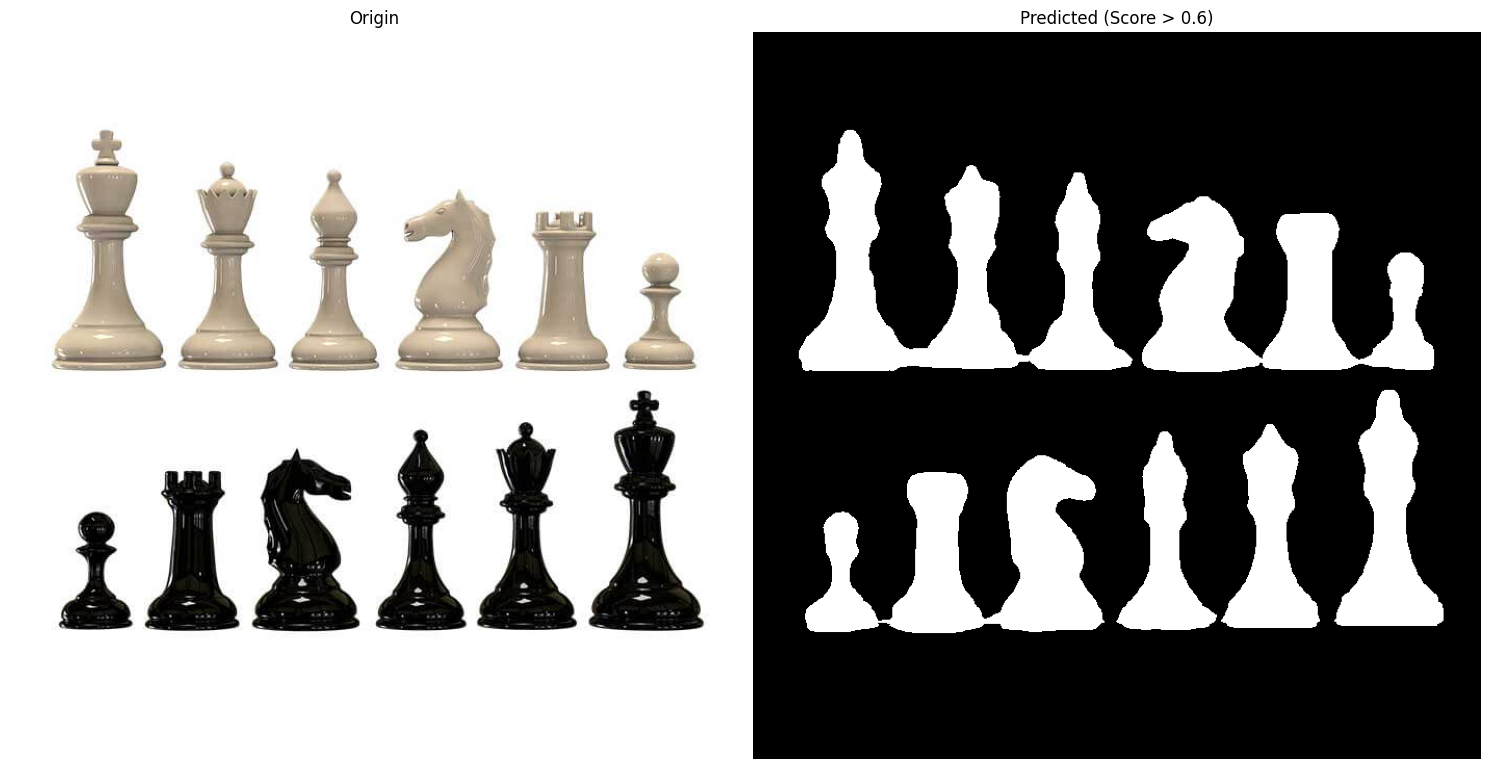

In [32]:

IMAGE_URL = "https://sportsmatik.com/uploads/matik-sports-corner/equipage/chess-pieces_1616130807.jpg"
MODEL_PATH = '/kaggle/working/best_model_epoch_7_iou_0.9572.pth' 
NUM_CLASSES = 2  
SCORE_THRESHOLD = 0.6
MASK_THRESHOLD = 0.6

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Sử dụng thiết bị: {device}")

model = get_model_instance_segmentation(NUM_CLASSES)
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.to(device)

original_image, binary_mask = predict_mask_only(model, IMAGE_URL, device,score_threshold=SCORE_THRESHOLD, mask_threshold=MASK_THRESHOLD)

if original_image and binary_mask:
    fig, axes = plt.subplots(1, 2, figsize=(15, 8)) 

    axes[0].imshow(original_image)
    axes[0].set_title("Origin")
    axes[0].axis('off') 

    axes[1].imshow(binary_mask, cmap='gray', vmin=0, vmax=255) # Dùng cmap='gray'
    axes[1].set_title(f"Predicted (Score > {SCORE_THRESHOLD})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

elif original_image is None:
    print("Lỗi khi tải ảnh gốc, không thể hiển thị.")
else:
    print("Không thể thực hiện dự đoán hoặc tạo mask.")